# SARIMAX

In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from electricity_price_predictor.data_2 import get_price
df = get_price()
df.head()

,time,price
0,01.01.2015 00:00,25.02
1,01.01.2015 01:00,18.29
2,01.01.2015 02:00,16.04
3,01.01.2015 03:00,14.6
4,01.01.2015 04:00,14.95


In [10]:
df['time'] = df.time.astype('datetime64')
df['price'] = df.price.astype('float')

### duplicated timestamps

In [11]:
df.time.value_counts().head(10)

2015-10-25 02:00:00    2
2017-10-29 02:00:00    2
2020-10-25 02:00:00    2
2016-10-30 02:00:00    2
2018-10-28 02:00:00    2
2019-10-27 02:00:00    2
2020-10-16 04:00:00    1
2015-11-30 23:00:00    1
2015-10-08 05:00:00    1
2018-03-31 21:00:00    1
Name: time, dtype: int64

**They are likely caused by daylight saving time, we should keep them since we actually had that timepoint**

In [101]:
'''df = df.drop(axis=0, index=50983)
df[df.time=='25.10.2020 02:00']
df = df.drop(axis=0, index=42247)
df[df.time=='27.10.2019 02:00']
df = df.drop(axis=0, index=7131)
df[df.time=='25.10.2015 02:00']
df = df.drop(axis=0, index=24772)
df[df.time=='29.10.2017 02:00']
df = df.drop(axis=0, index=33510)
df[df.time=='28.10.2018 02:00']
df = df.drop(axis=0, index=16035)
df[df.time=='30.10.2016 02:00']'''

"df = df.drop(axis=0, index=50983)\ndf[df.time=='25.10.2020 02:00']\ndf = df.drop(axis=0, index=42247)\ndf[df.time=='27.10.2019 02:00']\ndf = df.drop(axis=0, index=7131)\ndf[df.time=='25.10.2015 02:00']\ndf = df.drop(axis=0, index=24772)\ndf[df.time=='29.10.2017 02:00']\ndf = df.drop(axis=0, index=33510)\ndf[df.time=='28.10.2018 02:00']\ndf = df.drop(axis=0, index=16035)\ndf[df.time=='30.10.2016 02:00']"

### missing values

In [12]:
df[df.price.isnull()] 

,time,price
2090,2015-03-29 02:00:00,NaN
10827,2016-03-27 02:00:00,NaN
19564,2017-03-26 02:00:00,NaN
28301,2018-03-25 02:00:00,NaN
37206,2019-03-31 02:00:00,NaN
45943,2020-03-29 02:00:00,NaN


**They are likely caused by daylight saving time, we should drop them since we did not have this timepoints**

In [13]:
# drop nan
df=df[df.price.notna()]
df = df.set_index('time')

In [14]:
np.sort(df.price.unique())

array([-58.8 , -55.77, -53.62, ..., 148.18, 189.25, 200.04])

## Data exploration

### Decomposition

- components:
 - Trend
 - Seaonal
 - cyclical 

- choose:
 - additive or multiplicative decomposition?   plot the residuls of both models and decide  

- statsmodel.tsa [Deterministic Processes](https://www.statsmodels.org/stable/tsa.html#)      

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df, model='additive')
result_add.plot()

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [ ]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(df['price'], model='multiplicative')
result_mul.plot();

### Explore stationarity

In [18]:
df['log'] = df.price.apply(np.log)

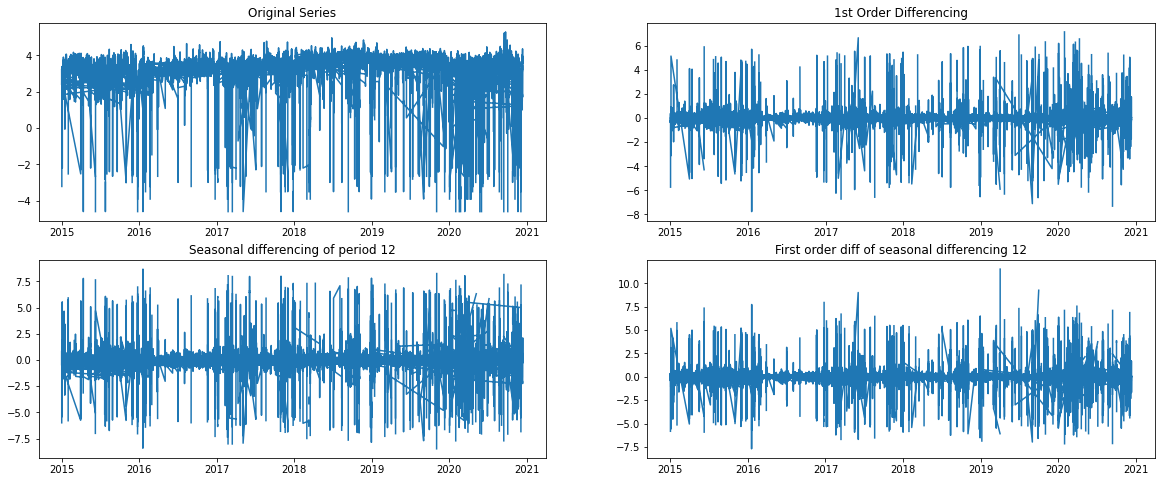

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))
# Original series
axs[0,0].plot(df.log); axs[0,0].set_title('Original Series')

# Normal differencing
axs[0,1].plot(df.log.diff(1)); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[1,0].plot(df.log.diff(12))
axs[1,0].set_title('Seasonal differencing of period 12')

# Sesonal + Normal differencing
axs[1,1].plot(df.log.diff(12).diff(1))
axs[1,1].set_title('First order diff of seasonal differencing 12');

In [31]:
# ADF test on lag day
day_ADF = adfuller(df.price, maxlag=24)
print(pd.Series(day_ADF[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic   -1.710292e+01
p-value           7.455653e-30
#Lags             2.400000e+01
Observations      5.169500e+04
dtype: float64


In [34]:
# ADF test on lag week
week_ADF = adfuller(df.price, maxlag=24*7)
print(pd.Series(week_ADF[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic       -5.523362
p-value               0.000002
#Lags               168.000000
Observations      51551.000000
dtype: float64


In [37]:
# ADF test on lag month **need GCP/Google colab to run it**
'''month_ADF = adfuller(df.price, maxlag=24*7*30)
print(pd.Series(month_ADF[0:4], index=['Test Statistic','p-value','#Lags','Observations']))'''

MemoryError: Unable to allocate 188. MiB for an array with shape (529, 46679) and data type float64

### Autocorrelation

In [ ]:
# plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df.value, lags=50, ax=axes[0]);
plot_pacf(df.value, lags=50, ax=axes[1], color='r')

## hyperparameters

In [ ]:
# grid search the hyper params
import pmdarima as pm
smodel = pm.auto_arima(train, seasonal=True, m=12, 
                       start_p=0, max_p=1, max_d=1, start_q=0, max_q=1,
                       start_P=0, max_P=2, max_D=1, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True) # The lower AIC the better

## SARIMAX Model

In [ ]:
# Create a correct Training/Test split to predict the last 50 points
train = df.linearized[0:150]
test = df.linearized[150:]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(engod=df['electricity_price'],
                 exog=df['day_of_week'],
                 order=(3, 0, 0),seasonal_order=(0,1,2,12)
                )
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05) # 95% confidence
forecast = results.predicted_mean
confidence_int = results.conf_int()

## Recomposition

In [ ]:
# re-compose back to initial time series

forecast_recons = np.exp(forecast)*result_mul.seasonal[150:]
train_recons = np.exp(train)*result_mul.seasonal[0:150]
test_recons = np.exp(test)*result_mul.seasonal[150:]
lower_recons = np.exp(confidence_int)[:,0]*result_mul.seasonal[150:]
upper_recons = np.exp(confidence_int)[:,1]*result_mul.seasonal[150:]

# plt 
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)

## Inference validity

In [ ]:
## plot residuals to see whether their normal distributed
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Prophet

[reference for model_b](https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1)